# Importing

In [ ]:
import pandas as pd
import string
import requests
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Getting the data

Refference:

https://www.kaggle.com/datasets/owaiskhan9654/pubmed-multilabel-text-classification

Download file from drive

In [ ]:
file_id = "1Og6j-0uOC-Di89rbTgq8Q3_bsoHAkPZ6"
url = f"https://drive.google.com/uc?export=download&id={file_id}"

output_file = "PubMed Multi Label Text Classification Dataset.csv"

response = requests.get(url)
if response.status_code == 200:
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print(f"File downloaded successfully as {output_file}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded successfully as PubMed Multi Label Text Classification Dataset.csv


In [ ]:
pubmed_data = pd.read_csv("PubMed Multi Label Text Classification Dataset.csv")

In [ ]:
pubmed_data.columns

Index(['Title', 'abstractText', 'meshMajor', 'pmid', 'meshid', 'meshroot', 'A',
       'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'V',
       'Z'],
      dtype='object')

Drop unused columns

In [ ]:
pubmed_data.drop(columns=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                          'M', 'N', 'V','Z'], inplace=True)

In [ ]:
pubmed_data.head()

,Title,abstractText,meshMajor,pmid,meshid,meshroot
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '..."
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'..."
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S..."
3,Multilayer capsules: a promising microencapsul...,"In 1980, Lim and Sun introduced a microcapsule...","['Acrylic Resins', 'Alginates', 'Animals', 'Bi...",11426874,"[['D05.750.716.822.111', 'D25.720.716.822.111'...","['Chemicals and Drugs [D]', 'Technology, Indus..."
4,"Nanohydrogel with N,N'-bis(acryloyl)cystine cr...",Substantially improved hydrogel particles base...,"['Antineoplastic Agents', 'Cell Proliferation'...",28323099,"[['D27.505.954.248'], ['G04.161.750', 'G07.345...","['Chemicals and Drugs [D]', 'Phenomena and Pro..."


In [ ]:
pubmed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         9999 non-null   object
 1   abstractText  10000 non-null  object
 2   meshMajor     10000 non-null  object
 3   pmid          10000 non-null  int64 
 4   meshid        10000 non-null  object
 5   meshroot      10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


Drop null value columns

In [ ]:
pubmed_data.dropna(inplace=True)

In [ ]:
pubmed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         9999 non-null   object
 1   abstractText  9999 non-null   object
 2   meshMajor     9999 non-null   object
 3   pmid          9999 non-null   int64 
 4   meshid        9999 non-null   object
 5   meshroot      9999 non-null   object
dtypes: int64(1), object(5)
memory usage: 546.8+ KB


In [ ]:
pubmed_data.columns = pubmed_data.columns.str.lower()

In [ ]:
pubmed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         9999 non-null   object
 1   abstracttext  9999 non-null   object
 2   meshmajor     9999 non-null   object
 3   pmid          9999 non-null   int64 
 4   meshid        9999 non-null   object
 5   meshroot      9999 non-null   object
dtypes: int64(1), object(5)
memory usage: 546.8+ KB


# Collecting unseen data for final evaluation

Collect last 10 rows to be unseen data

In [ ]:
keep = len(pubmed_data) - 10
tmp = pubmed_data
pubmed_data = tmp[:keep]
unseen_data = tmp[keep:]

In [ ]:
len(pubmed_data)

9989

In [ ]:
len(unseen_data)

10

# Exploring the data

What do meshroot look like?

In [ ]:
pubmed_data['meshroot'].loc[0]

"['Chemicals and Drugs [D]', 'Organisms [B]', 'Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]', 'Disciplines and Occupations [H]', 'Diseases [C]']"

In [ ]:
pubmed_data['meshroot'].loc[1]

"['Named Groups [M]', 'Chemicals and Drugs [D]', 'Psychiatry and Psychology [F]', 'Phenomena and Processes [G]', 'Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]', 'Health Care [N]', 'Organisms [B]', 'Geographicals [Z]', 'Diseases [C]', 'Anthropology, Education, Sociology, and Social Phenomena [I]', 'Technology, Industry, and Agriculture [J]']"

What do abstract text look like?

In [ ]:
pubmed_data['abstracttext'].loc[0]

'Fifty-four paraffin embedded tissue sections from patients with dysplasia (21 cases) and with cervical cancer (33 cases) were analysed. HPV was detected and identified in two stages. Firstly, using mixed starters, chosen genomic DNA sequences were amplified; secondly the material thus obtained was analyzed by hybridization method using oligonucleotyde 31-P labelled probe. HPVs of type 6, 11, 16, 18, 33 were identified. The p-53 expression was assayed by immunohistochemical method. HPV infection was often associated with dysplasia and cervical cancer. In cervical cancer mainly HPV 16 and 18 with high oncogenic potential were found. The p-53 was present rarely, and in minute quantities. No correlation was observed between presence of p-53 and HPVs DNA.'

In [ ]:
pubmed_data['abstracttext'].loc[1]

'The present cross-sectional study was conducted to determine the vitamin D status of pregnant Indian women and their breast-fed infants. Subjects were recruited from the Department of Obstetrics, Armed Forces Clinic and Army Hospital (Research and Referral), Delhi. A total of 541 apparently healthy women with uncomplicated, single, intra-uterine gestation reporting in any trimester were consecutively recruited. Of these 541 women, 299 (first trimester, ninety-seven; second trimester, 125; third trimester, seventy-seven) were recruited in summer (April-October) and 242 (first trimester, fifty-nine, second trimester, ninety-three; third trimester, ninety) were recruited in winter (November-March) to study seasonal variations in vitamin D status. Clinical, dietary, biochemical and hormonal evaluations for the Ca-vitamin D-parathormone axis were performed. A subset of 342 mother-infant pairs was re-evaluated 6 weeks postpartum. Mean serum 25-hydroxyvitamin D (25(OH)D) of pregnant women wa

How long the abstract text?

In [ ]:
pubmed_data.loc[:, 'abstracttext_length'] = pubmed_data['abstracttext'].apply(len)

In [ ]:
pubmed_data['abstracttext_length'].describe()

,abstracttext_length
count,9989.000000
mean,1306.862549
std,514.265092
min,79.000000
25%,946.000000
50%,1326.000000
75%,1654.000000
max,5470.000000


<Axes: ylabel='Frequency'>

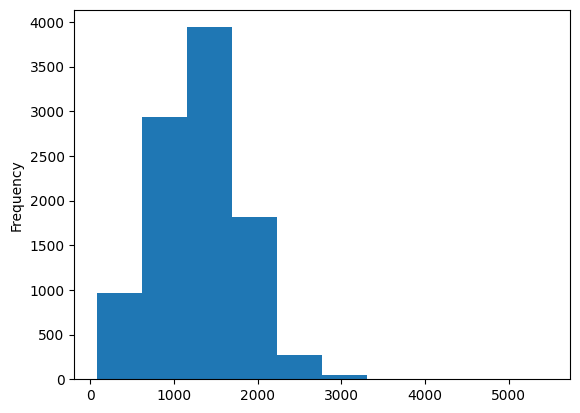

In [ ]:
pubmed_data['abstracttext_length'].plot.hist()

In [ ]:
pubmed_data.loc[:, 'is_diseases'] = pubmed_data['meshroot'].apply(lambda x: 'Diseases [C]' in x)
pubmed_data.head()

,title,abstracttext,meshmajor,pmid,meshid,meshroot,abstracttext_length,is_diseases
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",760,True
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",1747,True
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",693,False
3,Multilayer capsules: a promising microencapsul...,"In 1980, Lim and Sun introduced a microcapsule...","['Acrylic Resins', 'Alginates', 'Animals', 'Bi...",11426874,"[['D05.750.716.822.111', 'D25.720.716.822.111'...","['Chemicals and Drugs [D]', 'Technology, Indus...",1870,True
4,"Nanohydrogel with N,N'-bis(acryloyl)cystine cr...",Substantially improved hydrogel particles base...,"['Antineoplastic Agents', 'Cell Proliferation'...",28323099,"[['D27.505.954.248'], ['G04.161.750', 'G07.345...","['Chemicals and Drugs [D]', 'Phenomena and Pro...",1617,False


What are the most frequent words in the abstract text?

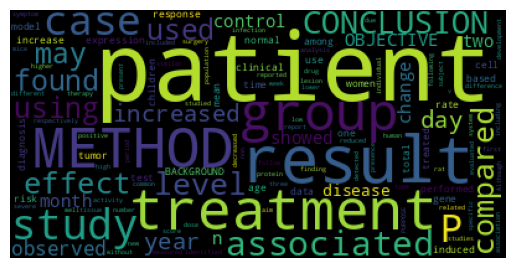

In [ ]:
text = list(pubmed_data[pubmed_data["is_diseases"] == True].abstracttext.values)

wordcloud = WordCloud(stopwords=STOPWORDS).generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
text = list(pubmed_data[pubmed_data["is_diseases"] == True].abstracttext.values)
text[:3]

['Fifty-four paraffin embedded tissue sections from patients with dysplasia (21 cases) and with cervical cancer (33 cases) were analysed. HPV was detected and identified in two stages. Firstly, using mixed starters, chosen genomic DNA sequences were amplified; secondly the material thus obtained was analyzed by hybridization method using oligonucleotyde 31-P labelled probe. HPVs of type 6, 11, 16, 18, 33 were identified. The p-53 expression was assayed by immunohistochemical method. HPV infection was often associated with dysplasia and cervical cancer. In cervical cancer mainly HPV 16 and 18 with high oncogenic potential were found. The p-53 was present rarely, and in minute quantities. No correlation was observed between presence of p-53 and HPVs DNA.',
 'The present cross-sectional study was conducted to determine the vitamin D status of pregnant Indian women and their breast-fed infants. Subjects were recruited from the Department of Obstetrics, Armed Forces Clinic and Army Hospital

# Cleaning & Preprocessing the data

In [ ]:
pubmed_data = pubmed_data.loc[pubmed_data['abstracttext_length'] > 200]

In [ ]:
pubmed_data = pubmed_data.loc[pubmed_data['abstracttext_length'] < 2000]

In [ ]:
pubmed_data['abstracttext_length'].describe()

,abstracttext_length
count,9197.000000
mean,1229.148309
std,428.195715
min,201.000000
25%,919.000000
50%,1273.000000
75%,1581.000000
max,1999.000000


<Axes: ylabel='Frequency'>

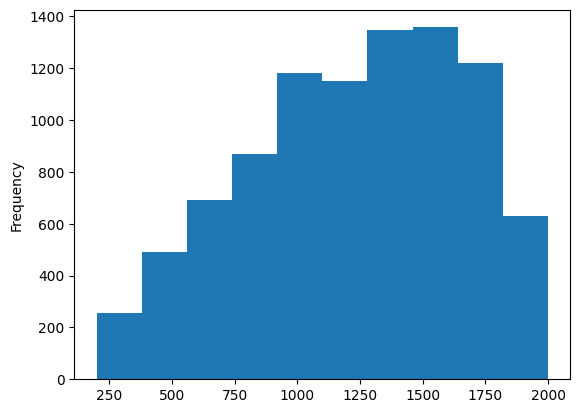

In [ ]:
pubmed_data['abstracttext_length'].plot.hist()

Remove punctuation

In [ ]:
exclude = set(string.punctuation)
def remove_punctoation(row):
  row.abstracttext = ''.join(ch for ch in row.abstracttext if ch not in exclude)
  return row

In [ ]:
pubmed_data = pubmed_data.apply(remove_punctoation, axis=1)

In [ ]:
pubmed_data.head()

,title,abstracttext,meshmajor,pmid,meshid,meshroot,abstracttext_length,is_diseases
0,Expression of p53 and coexistence of HPV in pr...,Fiftyfour paraffin embedded tissue sections fr...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",760,True
1,Vitamin D status in pregnant Indian women acro...,The present crosssectional study was conducted...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",1747,True
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",693,False
3,Multilayer capsules: a promising microencapsul...,In 1980 Lim and Sun introduced a microcapsule ...,"['Acrylic Resins', 'Alginates', 'Animals', 'Bi...",11426874,"[['D05.750.716.822.111', 'D25.720.716.822.111'...","['Chemicals and Drugs [D]', 'Technology, Indus...",1870,True
4,"Nanohydrogel with N,N'-bis(acryloyl)cystine cr...",Substantially improved hydrogel particles base...,"['Antineoplastic Agents', 'Cell Proliferation'...",28323099,"[['D27.505.954.248'], ['G04.161.750', 'G07.345...","['Chemicals and Drugs [D]', 'Phenomena and Pro...",1617,False


Lemmatisation

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(row):
  row.abstracttext = " ".join(lemmatizer.lemmatize(word) for word in row.abstracttext.split())
  return row

In [ ]:
pubmed_data = pubmed_data.apply(lemmatize_text, axis=1)

In [ ]:
pubmed_data.head()

,title,abstracttext,meshmajor,pmid,meshid,meshroot,abstracttext_length,is_diseases
0,Expression of p53 and coexistence of HPV in pr...,Fiftyfour paraffin embedded tissue section fro...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",760,True
1,Vitamin D status in pregnant Indian women acro...,The present crosssectional study wa conducted ...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",1747,True
2,[Identification of a functionally important di...,The occurrence of individual amino acid and di...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",693,False
3,Multilayer capsules: a promising microencapsul...,In 1980 Lim and Sun introduced a microcapsule ...,"['Acrylic Resins', 'Alginates', 'Animals', 'Bi...",11426874,"[['D05.750.716.822.111', 'D25.720.716.822.111'...","['Chemicals and Drugs [D]', 'Technology, Indus...",1870,True
4,"Nanohydrogel with N,N'-bis(acryloyl)cystine cr...",Substantially improved hydrogel particle based...,"['Antineoplastic Agents', 'Cell Proliferation'...",28323099,"[['D27.505.954.248'], ['G04.161.750', 'G07.345...","['Chemicals and Drugs [D]', 'Phenomena and Pro...",1617,False


# Converting the data into vectors

Count vectorizer

In [ ]:
vectorizer = CountVectorizer(lowercase = True, stop_words='english', max_features= 2000)
count_vectors = vectorizer.fit_transform(pubmed_data.abstracttext)

In [ ]:
count_vectors.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

TFIDF vectorizer

In [ ]:
TFIDF_vectorizer = TfidfVectorizer(lowercase = True, stop_words='english', max_features = 2000)
tfidf_vectors = TFIDF_vectorizer.fit_transform(pubmed_data.abstracttext)

In [ ]:
tfidf_vectors.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.30402656, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Modeling

Split to Train and Test

In [ ]:
X_count_train, X_count_test, y_count_train, y_count_test = train_test_split(count_vectors, list(pubmed_data.is_diseases), test_size=0.2, random_state=42)

In [ ]:
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(tfidf_vectors, list(pubmed_data.is_diseases), test_size=0.2, random_state=42)

Multinomial naive bayes

In [ ]:
model = MultinomialNB()
model.fit(X_count_train, y_count_train)
score_train = model.score(X_count_train, y_count_train)
score_test = model.score(X_count_test, y_count_test)
print("\nTrain set score:", score_train)
print("Test set score:", score_test)


Train set score: 0.8276471387793938
Test set score: 0.8222826086956522


In [ ]:
y_pred = model.predict(X_count_test)

Decision tree

In [ ]:
dt_model = DecisionTreeClassifier(max_depth=15, random_state=0)
dt_model.fit(X_tfidf_train, y_tfidf_train)
score_train = dt_model.score(X_tfidf_train, y_tfidf_train)
score_test = dt_model.score(X_tfidf_test, y_tfidf_test)
print("\nTrain set score:", score_train)
print("Test set score:", score_test)


Train set score: 0.8731820035340492
Test set score: 0.7940217391304348


In [ ]:
y_dt_pred = dt_model.predict(X_tfidf_test)

# Evaluating

Count vectorizer

In [ ]:
confusion_matrix(y_count_test, y_pred)

array([[749, 141],
       [186, 764]])

In [ ]:
print(classification_report(y_count_test, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.84      0.82       890
        True       0.84      0.80      0.82       950

    accuracy                           0.82      1840
   macro avg       0.82      0.82      0.82      1840
weighted avg       0.82      0.82      0.82      1840



TFIDF vectorizer

In [ ]:
confusion_matrix(y_tfidf_test, y_dt_pred)

array([[766, 124],
       [255, 695]])

In [ ]:
print(classification_report(y_tfidf_test, y_dt_pred))

              precision    recall  f1-score   support

       False       0.75      0.86      0.80       890
        True       0.85      0.73      0.79       950

    accuracy                           0.79      1840
   macro avg       0.80      0.80      0.79      1840
weighted avg       0.80      0.79      0.79      1840



# Interface

In [ ]:
unseen_data

,title,abstracttext,meshmajor,pmid,meshid,meshroot
9990,Fully intact contact heat evoked potentials in...,Amyotrophic lateral sclerosis (ALS) is typical...,"['Adult', 'Afferent Pathways', 'Aged', 'Amyotr...",19260053,"[['M01.060.116'], ['A08.612.220'], ['M01.060.1...","['Named Groups [M]', 'Anatomy [A]', 'Diseases ..."
9991,Chemical studies on the structure of mucopepti...,Mucopeptides isolated from Streptococcus bovis...,"['Alanine', 'Cell Wall', 'Chromatography, Ion ...",5802603,"[['D12.125.042'], ['A11.284.183'], ['E05.196.1...","['Chemicals and Drugs [D]', 'Anatomy [A]', 'An..."
9992,Three-dimensional CT modeling versus tradition...,"Recently, the authors have used the computer-g...","['Acetabulum', 'Adult', 'Fractures, Bone', 'Hu...",11813946,"[['A02.835.232.043.825.108'], ['M01.060.116'],...","['Anatomy [A]', 'Named Groups [M]', 'Diseases ..."
9993,Early pregnancy testing and its relationship t...,A total of 487 Standardbred and Thoroughbred m...,"['Abortion, Veterinary', 'Animals', 'Australia...",1060828,"[['C13.703.039.422', 'C22.021'], ['B01.050'], ...","['Diseases [C]', 'Organisms [B]', 'Geographica..."
9994,Macrophages as delivery vehicles for anticance...,The delivery of anticancer agents via passive ...,"['Animals', 'Antigen-Presenting Cells', 'Antin...",30909858,"[['B01.050'], ['A11.066', 'A15.382.066'], ['D2...","['Organisms [B]', 'Anatomy [A]', 'Chemicals an..."
9995,Smoking Lung Cancer Patients and Tobacco Cessa...,Lung cancer is the most preventable neoplastic...,"['Adolescent', 'Adult', 'Age Distribution', 'A...",26398407,"[['M01.060.057'], ['M01.060.116'], ['I01.240.0...","['Named Groups [M]', 'Anthropology, Education,..."
9996,Lipid and lipoprotein parameters for detection...,BACKGROUND: Familial hypercholesterolaemia (FH...,"['Achilles Tendon', 'Adolescent', 'Apolipoprot...",29602595,"[['A02.880.176'], ['M01.060.057'], ['D10.532.0...","['Anatomy [A]', 'Named Groups [M]', 'Chemicals..."
9997,Preparation of folate-modified pullulan acetat...,The purpose of this work was to develop a nove...,"['Acetylation', 'Antibiotics, Antineoplastic',...",22747075,"[['G02.111.012.052', 'G02.607.063.052', 'G03.0...","['Phenomena and Processes [G]', 'Chemicals and..."
9998,Fashion advertisements: a comparison of viewer...,The perceptual and affective responses of 44 w...,"['Adult', 'Advertising', 'Affect', 'Aged', 'Ar...",1484770,"[['M01.060.116'], ['J01.219.687.274', 'L01.143...","['Named Groups [M]', 'Technology, Industry, an..."
9999,[Hypotension in Austria (author's transl)].,A representative group of the Austrian populat...,"['Adolescent', 'Adult', 'Age Factors', 'Aged',...",7257424,"[['M01.060.057'], ['M01.060.116'], ['N05.715.3...","['Named Groups [M]', 'Health Care [N]', 'Psych..."


In [ ]:
answer_list = []
for i in range(len(unseen_data)):
  if 'Diseases [C]' in unseen_data.iloc[i].meshroot:
    print(unseen_data.index[i], True)
    answer_list.append(True)
  else:
    print(unseen_data.index[i], False)
    answer_list.append(False)
answer_array = np.array(answer_list)
answer_array

9990 True
9991 False
9992 True
9993 True
9994 True
9995 True
9996 True
9997 False
9998 False
9999 True


array([ True, False,  True,  True,  True,  True,  True, False, False,
        True])

In [ ]:
unseen_data = unseen_data.apply(remove_punctoation, axis=1)
unseen_data = unseen_data.apply(lemmatize_text, axis=1)
unseen_data_count_vectors = vectorizer.transform(unseen_data.abstracttext)
unseen_data_tfidf_vectors = TFIDF_vectorizer.transform(unseen_data.abstracttext)

Count vectorizer

In [ ]:
y_unseen_count_vectoers = model.predict(unseen_data_count_vectors)
y_unseen_count_vectoers

array([ True, False,  True,  True, False,  True,  True, False, False,
        True])

In [ ]:
confusion_matrix(answer_array, y_unseen_count_vectoers)

array([[3, 0],
       [1, 6]])

In [ ]:
print(classification_report(answer_array, y_unseen_count_vectoers))

              precision    recall  f1-score   support

       False       0.75      1.00      0.86         3
        True       1.00      0.86      0.92         7

    accuracy                           0.90        10
   macro avg       0.88      0.93      0.89        10
weighted avg       0.93      0.90      0.90        10



TFIDF vectorizer

In [ ]:
y_unseen_tfidf_vectors = dt_model.predict(unseen_data_tfidf_vectors)
y_unseen_tfidf_vectors

array([ True, False,  True, False,  True,  True, False, False, False,
       False])

In [ ]:
confusion_matrix(answer_array, y_unseen_tfidf_vectors)

array([[3, 0],
       [3, 4]])

In [ ]:
print(classification_report(answer_array, y_unseen_tfidf_vectors))

              precision    recall  f1-score   support

       False       0.50      1.00      0.67         3
        True       1.00      0.57      0.73         7

    accuracy                           0.70        10
   macro avg       0.75      0.79      0.70        10
weighted avg       0.85      0.70      0.71        10

